In [1]:
import gradio as gr
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from demo.cam import generate_gradcam, GradCAM
from captum.attr import LayerGradCam
from PIL import Image
from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt
import os
import time

c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


c:\Users\Austi\anaconda3\envs\janus_env\lib\site-packages\transformers\models\auto\image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:

model_path = "deepseek-ai/Janus-Pro-1B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)

dtype = torch.bfloat16 if torch.cuda.is_available() else torch.float16
# dtype = torch.bfloat32 if torch.cuda.is_available() else torch.float32

if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(dtype).cuda()
else:
    # vl_gpt = vl_gpt.to(torch.float16)
    torch.set_default_device("mps")
    vl_gpt = vl_gpt.to(dtype)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'mps'

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused and will not have any effect: image_tag, ignore_id, sft_format, num_image

In [3]:
def multimodal_understanding(image, question, seed, top_p, temperature, target):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()


    for param in vl_gpt.parameters():
        param.requires_grad = True
    
    # set seed
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    

    # Get the last transformer block of the Vision Transformer (ViT)


    conversation = [
        {
            "role": "<|User|>",
            "content": f"<image_placeholder>\n{question}",
            "images": [image],
        },
        {"role": "<|Assistant|>", "content": ""},
    ]
    
    pil_images = [Image.fromarray(image)]
    prepare_inputs = vl_chat_processor(
        conversations=conversation, images=pil_images, force_batchify=True
    ).to(cuda_device, dtype=dtype)
    


    print("prepare_inputs: ", prepare_inputs)

    print("generating guided gradcam...")

    import torch.nn as nn

    class ViTForGradCAM(nn.Module):
        def __init__(self, vision_model, aligner, language_model):
            super().__init__()
            self.vision_model = vision_model
            self.aligner = aligner
            self.language_model = language_model

        def forward(self,
            input_ids: torch.LongTensor,
            pixel_values: torch.FloatTensor,
            images_seq_mask: torch.LongTensor,
            images_emb_mask: torch.LongTensor,
            **kwargs,
            ):
            bs, n = pixel_values.shape[0:2]
            images = rearrange(pixel_values, "b n c h w -> (b n) c h w")
            images_embeds = self.aligner(self.vision_model(images))  # shape: [batch, T, D]
            
            # [b x n, T2, D] -> [b, n x T2, D]
            images_embeds = rearrange(images_embeds, "(b n) t d -> b (n t) d", b=bs, n=n)
            # [b, n, T2] -> [b, n x T2]
            images_emb_mask = rearrange(images_emb_mask, "b n t -> b (n t)")



            # [b, T, D]
            input_ids[input_ids < 0] = 0  # ignore the image embeddings
            # print("input_ids: ", input_ids)

            inputs_embeds = self.language_model.get_input_embeddings()(input_ids)
            # print("input_embeddings: ", inputs_embeds)

            # replace with the image embeddings
            inputs_embeds[images_seq_mask] = images_embeds[images_emb_mask]


            outputs = vl_gpt.language_model(
                inputs_embeds=inputs_embeds,
                attention_mask=prepare_inputs.attention_mask,
                pad_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                max_new_tokens=512,
                do_sample=False if temperature == 0 else True,
                use_cache=True,
                temperature=temperature,
                top_p=top_p,
            )

            
            # return inputs_embeds
            return outputs
        


    # Wrap your vision model
    vit_scalar_model = ViTForGradCAM(vl_gpt.vision_model, vl_gpt.aligner, vl_gpt.language_model)
    # target_layer = vit_scalar_model.vision_model.vision_tower.blocks[-1].norm2
    target_layer = vit_scalar_model.vision_model.vision_tower.norm

    # output = vit_scalar_model(**prepare_inputs)
    

    # Compute the attributions.
    gradcam = GradCAM(vit_scalar_model, target_layer)
    cam_tensor, output = gradcam(prepare_inputs, tokenizer, temperature, top_p, target_token_idx=target)

    input_ids = prepare_inputs.input_ids[0].cpu().tolist()
    input_ids_decoded = [tokenizer.decode([input_ids[i]]) for i in range(len(input_ids))]
    
    
    return output, cam_tensor, input_ids_decoded

In [14]:
# IMG_PATH = "../images/doge.png"
# question = "explain this meme."

IMG_PATH = "../images/AreaChart.png"
question = "You should read the question carefully. What is the coffee price in April 2019? Give me a brief explanation"

image = Image.open(IMG_PATH)
image_arr = np.array(image)
target_token_idx = 640

output, cam_tensor, input_ids_decoded = multimodal_understanding(image_arr, question, 100, 0.95, 0, target=target_token_idx)


prepare_inputs:  BatchedVLChatProcessorOutput(sft_format=['You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\n<|User|>: <image_placeholder>\nYou should read the question carefully. What is the coffee price in April 2019? Give me a brief explanation\n\n<|Assistant|>:'], input_ids=tensor([[100000,   2054,    418,    245,   9394,   4706,    285,  10046,  20308,
             13,   1257,    418,   2249,    276,   2579,    254,   7959,   3093,
            344,    254,   2677,   4614,     11,    285,   4750,    254,   2677,
            366,    245,   6265,    280,   9224,   1244,   3892,   4706,     13,
            185,    185, 100588,     25,    207, 100003, 100581, 100581, 100581,
         100581, 100581, 100581, 100581, 100581, 100581, 100581, 100581, 100581,
         100581, 100581, 100581, 100581, 100581, 100581, 100581, 100581, 100581,
         10058

In [15]:
output_arr = output.logits.detach().to(float).to("cpu").numpy()
output_arr.shape

(1, 649, 102400)

In [16]:
cam_tensor_arr = cam_tensor.detach().to(float).to("cpu").numpy()
cam_tensor_arr.shape

(1, 576)

Generating Grad-CAM with attributions shape: torch.Size([24, 24])


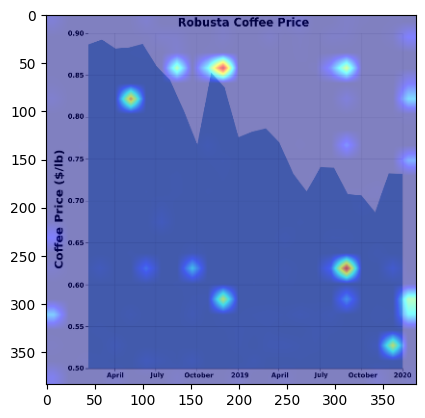

In [17]:
cam_grid = cam_tensor.reshape(24, 24)


cam = generate_gradcam(cam_grid, image)

plt.imshow(cam)
plt.show(cam)

In [18]:
predicted_ids = np.argmax(output_arr, axis=-1) # [1, num_tokens]
predicted_ids = predicted_ids.squeeze(0) # [num_tokens]
answer = tokenizer.decode(predicted_ids[target_token_idx].tolist())
# answer = tokenizer.decode(predicted_ids.tolist())
answer

' the'

In [19]:
answer = tokenizer.decode(predicted_ids.tolist())
answer

'就算 are given software AI model culture assistant.\n can a to understand and language content of is user is and and you them user in the wide of tasks. the language.\n\nHerelHello\n\x0b be up9,Stock" to\nankbanele, Shop Shop\n.\n to�Coffee\n.. (90 range\n of shows\nuntella Coffee Coffee Price Price Price Book"\n\n,  year plot with prices9 is,,,,\n\n coffee Coffee Coffee Coffee Prices prices"\n\n dailyes, prices prices with"5 ,,,, rate1 prices1<｜begin▁of▁sentence｜>., prices" prices,o Materials data coffee coffeeAI“9,  range8 green-, price in,\n coffee. prices prices.5 coffee of title [ to\'. with. has Materials blue.- data,, trend background background,\n. data0 grid0 data Positive of80 - range of, data-, peaks, further further further\n58. prices is displays displays,.87 from range peak blue,-, peaks. peaks peaks... price prices blue coffee. per isw" labeled5 prices€) coffee,,, blue.,..,, data�grapnL\n)7,  range price prices prices5, price,, shape,-.\n trends Januarylog shows\n0bb y -y

In [10]:
input_ids_decoded_str = ""
for token_decoded in input_ids_decoded:
    input_ids_decoded_str += token_decoded
input_ids_decoded_str

'<｜begin▁of▁sentence｜>You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language.\n\n<|User|>: <begin_of_image><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><image_placeholder><i

In [20]:
input_ids_decoded

['<｜begin▁of▁sentence｜>',
 'You',
 ' are',
 ' a',
 ' helpful',
 ' language',
 ' and',
 ' vision',
 ' assistant',
 '.',
 ' You',
 ' are',
 ' able',
 ' to',
 ' understand',
 ' the',
 ' visual',
 ' content',
 ' that',
 ' the',
 ' user',
 ' provides',
 ',',
 ' and',
 ' assist',
 ' the',
 ' user',
 ' with',
 ' a',
 ' variety',
 ' of',
 ' tasks',
 ' using',
 ' natural',
 ' language',
 '.',
 '\n',
 '\n',
 '<|User|>',
 ':',
 ' ',
 '<begin_of_image>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 '<image_placeholder>',
 

In [21]:
input_ids_decoded[target_token_idx]

' Give'

In [22]:
output

CausalLMOutputWithPast(loss=None, logits=tensor([[[22.1250, 23.8750, 22.0000,  ..., 13.7500, 13.8125, 13.7500],
         [65.5000, 62.7500, 60.5000,  ..., 52.5000, 52.5000, 52.5000],
         [60.5000, 57.2500, 52.0000,  ..., 51.0000, 51.0000, 51.0000],
         ...,
         [54.7500, 57.7500, 53.0000,  ..., 42.0000, 42.0000, 42.0000],
         [-5.4062, -5.5312, -8.4375,  ...,  2.7188,  2.6875,  2.6719],
         [50.5000, 55.0000, 50.2500,  ..., 38.7500, 38.7500, 38.7500]]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<UnsafeViewBackward0>), past_key_values=DynamicCache(), hidden_states=None, attentions=None)